In [281]:
import sklearn
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np

In [282]:
import warnings
warnings.filterwarnings('ignore')

## Импортируем данные
> target = `df['MedHouseVal']`

In [283]:
df = fetch_california_housing(as_frame=True)['frame']
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Сомнительные признаки `Latitude` и `Longitude`, они заточены под штат Калифорния, а значит в другой точке земного шара будет работать хуже.
### В рамках этой задачи, эти параметры отсавим

## Анализ и предобработка данных

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### Нелевых данных нет, это хорошо!

#### Смотрим на выборочное среднее

In [285]:
df.mean()

MedInc            3.870671
HouseAge         28.639486
AveRooms          5.429000
AveBedrms         1.096675
Population     1425.476744
AveOccup          3.070655
Latitude         35.631861
Longitude      -119.569704
MedHouseVal       2.068558
dtype: float64

In [286]:
df_data = df[df.columns[:-1]]
df_target = df[[df.columns[-1]]]

In [287]:
import seaborn as sns

<AxesSubplot:>

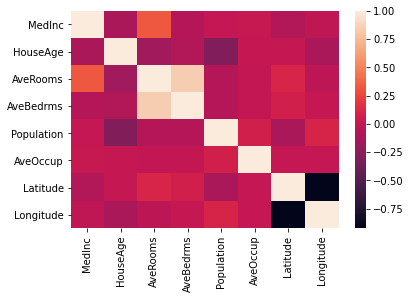

In [288]:
sns.heatmap(df_data.corr())

### Можно заметить, что `AveRooms` и `AveBedrms` достаточно сильно корелируют между собой, поэтому отбросим один из признаков

In [289]:
# df_data = df_data.drop(['AveBedrms', "Latitude", "Longitude"], axis=1)
df_data = df_data.drop(['AveBedrms'], axis=1)

In [290]:
df_data.head()

,MedInc,HouseAge,AveRooms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,565.0,2.181467,37.85,-122.25


In [291]:
import matplotlib.pyplot as plt

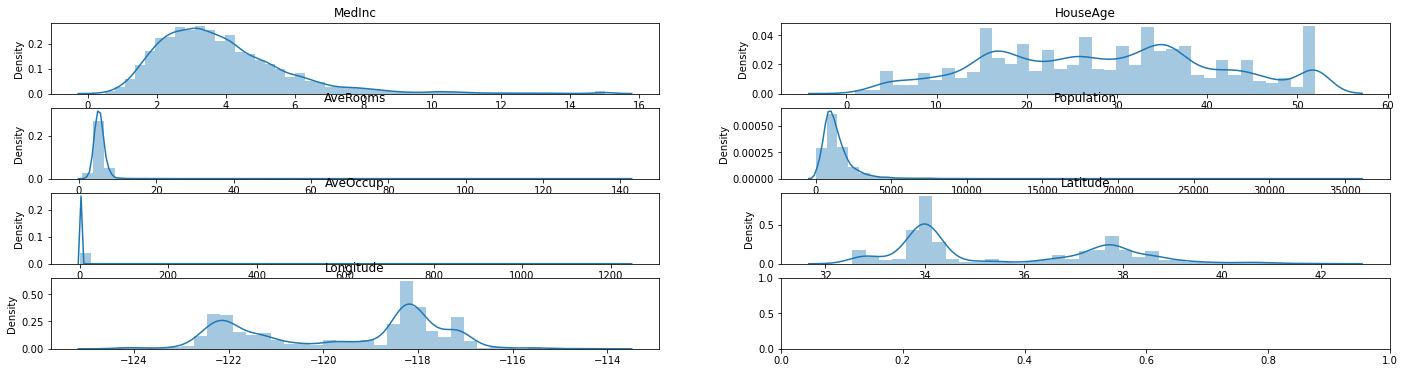

In [292]:
fig, axes = plt.subplots(4, 2, figsize = (24, 6))
for ax, col in zip(axes.flatten(), df_data.columns):
    sns.distplot(df[col].values, ax=ax)
    ax.set_title(col)

In [293]:
df_disp = ((df_data - df_data.mean()).pow(2)).sum(axis=0)/(df_data.shape[0]-1)

In [294]:
df_disp = ((df_data - df_data.mean())**2).sum(axis=0)/(df_data.shape[0]-1)

In [295]:
import math

In [296]:
df_data_prep = (df_data - df_data.mean())/(df_disp*2)
# df_data_prep = df_data.copy(deep=True)

In [297]:
df_data_prep.mean()

MedInc       -6.554942e-15
HouseAge      6.808386e-17
AveRooms      9.232282e-16
Population   -4.236141e-20
AveOccup     -3.509338e-17
Latitude     -1.891943e-14
Longitude    -3.568641e-13
dtype: float64

In [298]:
df_data_prep.min()

MedInc       -0.466953
HouseAge     -0.087248
AveRooms     -0.374322
Population   -0.000555
AveOccup     -0.011024
Latitude     -0.338850
Longitude    -0.595432
dtype: float64

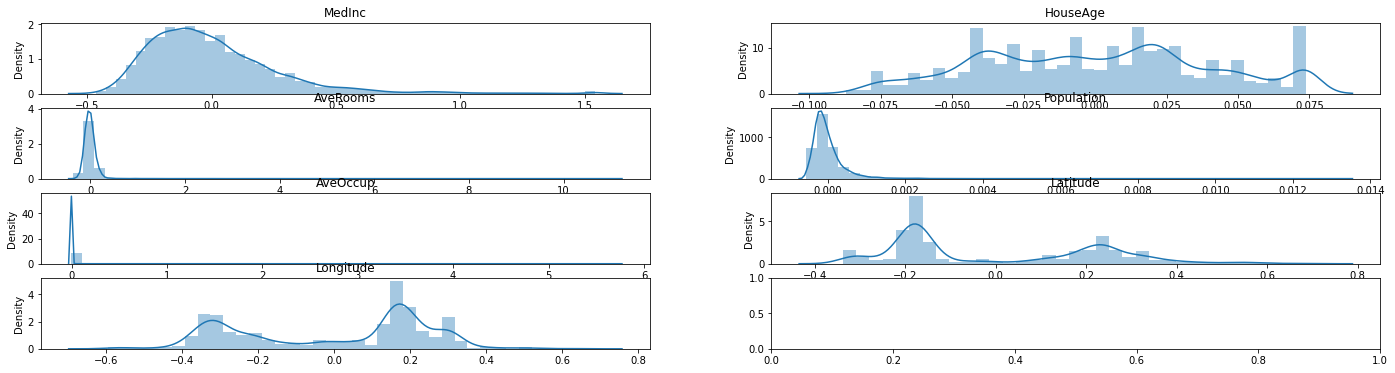

In [299]:
fig, axes = plt.subplots(4, 2, figsize = (24, 6))
for ax, col in zip(axes.flatten(), df_data_prep.columns):
    sns.distplot(df_data_prep[col].values, ax=ax)
    ax.set_title(col)

<AxesSubplot:>

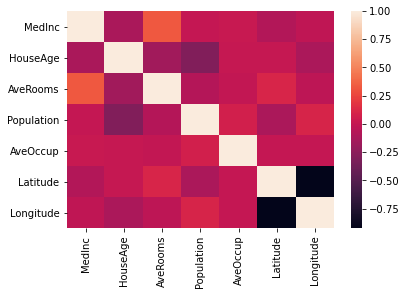

In [300]:
sns.heatmap(df_data_prep.corr())

In [301]:
def reg_one(weights, lam):
    return lam * (weights ** 2).sum()
def reg_two(weights, lam=10):
    return lam * np.abs(weights).sum()

def MSE(x, weights, target, reg=1, lam=10, r=False):
    if not r:
        reg = lambda x: x * 0
    elif reg == 1:
        reg = reg_one
    else:
        reg = reg_two
    return ((x-target)**2).sum(axis=1) + reg(weights, lam)

In [302]:
def regres(x, weights):
    return x.dot(weights)

In [303]:
def gradient(x, 
             weights, 
             y,
             reg=1,
             lam=10,
             r=False,
             func=regres, 
             loss_func=MSE, 
             step=0.01):
    
    delt = 0.000000001
    d_mat = np.eye(weights.shape[0]) * delt
    X = np.array([func(x, weights) for num in range(d_mat.shape[0])])
    X_d = np.array([func(x, weights + d_mat[num]) for num in range(d_mat.shape[0])])
    f_d = (loss_func(X_d, weights, y, lam=lam, reg=reg, r=r) - loss_func(X, weights, y, lam=lam, reg=reg, r=r))/delt
    weights = weights - step * f_d/(2*x.shape[0])
    return weights

In [304]:
from sklearn.model_selection import KFold

In [305]:
x = df_data_prep.values
y = df_target.values.flatten()
disp_y = ((y - y.mean())**2).sum()/(y.shape[0]-1)
y =  (y - y.mean())/(2 * disp_y) 

In [306]:
kf = KFold(n_splits=4, shuffle=True)

In [307]:
list(kf.split(x))

[(array([    0,     2,     3, ..., 20637, 20638, 20639]),
  array([    1,     8,    14, ..., 20626, 20635, 20636])),
 (array([    0,     1,     2, ..., 20636, 20637, 20638]),
  array([    3,     5,     6, ..., 20631, 20632, 20639])),
 (array([    1,     2,     3, ..., 20636, 20637, 20639]),
  array([    0,     4,    16, ..., 20623, 20628, 20638])),
 (array([    0,     1,     3, ..., 20636, 20638, 20639]),
  array([    2,     9,    11, ..., 20633, 20634, 20637]))]

In [308]:
a = np.array([1,2,3])

In [309]:
def RMSE(pred, target):
    return np.sqrt(((pred.flatten() - target) ** 2).sum()/pred.flatten().shape[0])
def r2_score(pred, target):
    return 1 - ((pred-target)**2).sum()/((pred - target.mean())**2).sum()

In [319]:
lam = 10
reg = 2
step = 0.1
R = True

In [346]:
rmse_cross_test, rmse_cross_train = [], []
r2_cross_train, r2_cross_test = [], []
for train_index, test_index in list(kf.split(x)):
    tmp_tr_r2, tmp_te_r2 = [], []
    tmp_tr_rmse, tmp_te_rmse = [], [] 
    x_train, y_train = x[train_index], y[train_index]
    x_test, y_test = x[test_index], y[test_index]
    weights = np.random.rand(len(df_data_prep.columns))
    for k in range(1000):
        weights = gradient(x_train, weights, y_train, lam=lam, reg=reg, step=step, r=R)
        val_train = x_train.dot(weights)
        val_test = x_test.dot(weights)

        tmp_te_rmse.append(RMSE(val_test, y_test))
        tmp_tr_rmse.append(RMSE(val_train, y_train))
        
        tmp_tr_r2.append(r2_score(val_train, y_train))
        tmp_te_r2.append(r2_score(val_test, y_test))
    
    r2_cross_test.append(tmp_te_r2)
    r2_cross_train.append(tmp_tr_r2)
    
    rmse_cross_test.append(tmp_te_rmse)
    rmse_cross_train.append(tmp_tr_rmse) 

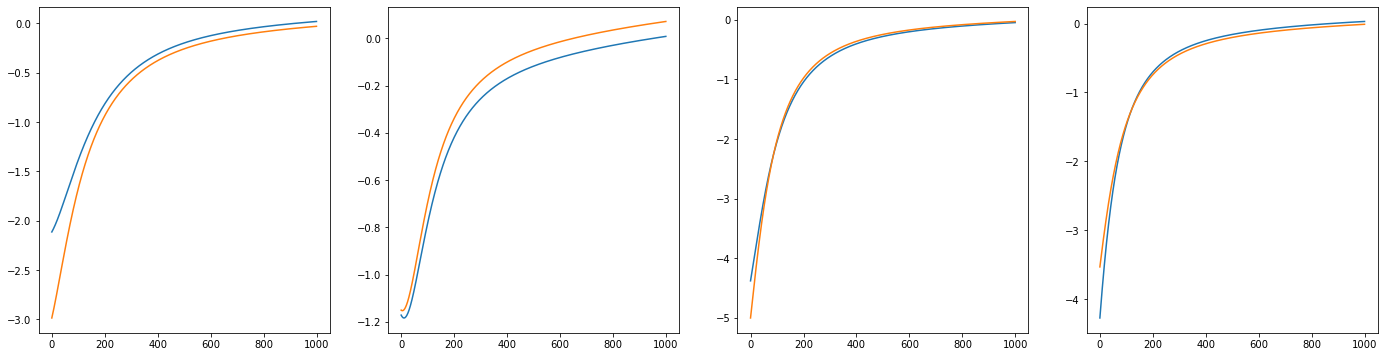

In [348]:
fig, axes = plt.subplots(1,kf.n_splits, figsize=(24, 6))
for ax, test, train in zip(axes, r2_cross_test, r2_cross_train):
    ax.plot(train)
    ax.plot(test)

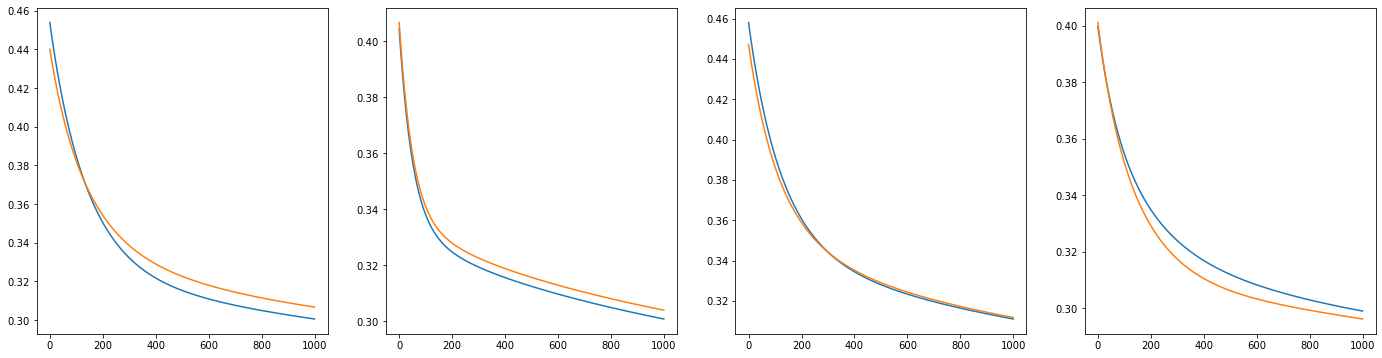

In [347]:
fig, axes = plt.subplots(1,kf.n_splits, figsize=(24, 6))
for ax, test, train in zip(axes, rmse_cross_test, rmse_cross_train):
    ax.plot(train)
    ax.plot(test)

In [326]:
r2_cross_train[-1]

0.02657121555478892

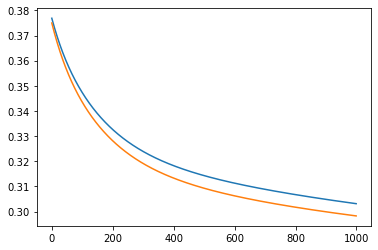

In [327]:
plt.plot(rmse_cross_val)
plt.plot(rmse_cross_train)

In [349]:
weights

array([ 1.15343344,  0.69742634, -0.14711212,  0.25024926,  0.03448479,
       -0.26753628, -0.21800925])

In [238]:
max(y) - min(y)

1.8211046995794646

In [32]:
RMSE(x.dot(weights), y)

2.2201154446816718

In [405]:
x.dot(weights)

array([ 1.72656384,  1.70260836,  1.32793042, ..., -1.0574349 ,
       -0.98439345, -0.78732694])

In [406]:
weights

array([ 1.38349478e+00,  1.37708362e-01, -1.13859932e-02, -2.81696105e-04,
       -3.36824835e-02, -4.22897896e-01, -3.31154401e-01])

In [407]:
regres(x, weights)

array([ 1.72656384,  1.70260836,  1.32793042, ..., -1.0574349 ,
       -0.98439345, -0.78732694])

In [408]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])